In [27]:
#Import all the necessary packages
from pandas import Series, DataFrame
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score
from patsy import dmatrices
import warnings
import seaborn as sns
import xgboost as xgb
from xgboost import plot_tree
from xgboost import plot_importance
from sklearn.metrics import PrecisionRecallDisplay

%pylab inline
warnings.filterwarnings('ignore')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Decision Tree

In [2]:
#Import the training set
train = pd.read_csv("train.csv")
train.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,insulin,change,...,diag_2_Other,diag_2_Respiratory,diag_3_Diabetes,diag_3_Digestive,diag_3_Genitourinary,diag_3_Injury,diag_3_Musculoskeletal,diag_3_Other,diag_3_Respiratory,readmitted
0,5.0,59.0,0.0,10.0,0.0,0.0,0.0,9.0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,3.0,32.0,6.0,17.0,0.0,0.0,0.0,6.0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3.0,56.0,0.0,9.0,0.0,0.0,0.0,5.0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,10.0,46.0,0.0,30.0,0.0,1.0,1.0,8.0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,4.0,58.0,3.0,13.0,0.0,0.0,0.0,8.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
#Get a list of all column names besides the predictor "readmitted" column
column_headers = train.columns.values.tolist()
column_headers = column_headers[:-1]

In [4]:
#Set the x and y training sets
X_train = train[column_headers]
y_train = train['readmitted']

In [5]:
#Import the test set
test = pd.read_csv("test.csv")
test.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,insulin,change,...,diag_2_Other,diag_2_Respiratory,diag_3_Diabetes,diag_3_Digestive,diag_3_Genitourinary,diag_3_Injury,diag_3_Musculoskeletal,diag_3_Other,diag_3_Respiratory,readmitted
0,2.5,45.5,0.0,10.5,0.0,0.0,0.5,7.5,0,0,...,1,0,0,1,0,0,0,0,0,1
1,2.0,72.0,0.0,15.0,0.0,0.0,0.0,4.0,1,1,...,1,0,0,0,0,0,0,1,0,1
2,5.0,51.0,0.0,10.0,0.0,0.0,0.0,9.0,0,0,...,1,0,1,0,0,0,0,0,0,0
3,10.0,81.0,2.0,35.0,0.0,0.0,0.0,9.0,1,1,...,0,1,0,0,0,0,0,1,0,0
4,1.0,26.0,1.0,12.0,0.0,0.0,0.0,4.0,1,1,...,1,0,0,0,0,0,0,1,0,0


In [6]:
#Set the x and y test sets
X_test = test[column_headers]
y_test = test['readmitted']

In [7]:
#Import the decision tree package and set the class weights as discussed in the group meeting
from sklearn import tree
decision_tree_1 = tree.DecisionTreeClassifier(criterion='entropy', class_weight={0:1,1:2})

In [8]:
#Fit the model
result = decision_tree_1.fit(X_train, y_train)

In [9]:
#Print the accuracy score on the training set
from sklearn import metrics

prediction_train = decision_tree_1.predict(X_train)
print(metrics.accuracy_score(y_train, prediction_train))

1.0


In [10]:
#Print the accuracy score on the test set
prediction = decision_tree_1.predict(X_test)
print(metrics.accuracy_score(y_test, prediction))

0.6903929354590174


### Since the above decision tree is overfit, I have made another one below with a max_depth of 2

In [11]:
#Run the decision tree again with a depth of two to improve accuracy and avoid overfitting
decision_tree_2 = tree.DecisionTreeClassifier(criterion='entropy', max_depth=2, class_weight={0:1,1:2})
result = decision_tree_2.fit(X_train, y_train)

In [12]:
#Print the accuracy on the training set
prediction_train = decision_tree_2.predict(X_train)
print(metrics.accuracy_score(y_train, prediction_train))

0.766501373056483


In [13]:
#Print the accuracy on the test set
prediction = decision_tree_2.predict(X_test)
print(metrics.accuracy_score(y_test, prediction))

0.7750844544538612


In [14]:
#Visually display the decision tree
import graphviz
graphviz.Source(tree.export_graphviz(decision_tree_2,
                                     out_file=None,
                                     feature_names=X_train.columns.values,
                                     filled=True))
index=X_train.columns.to_list()

In [15]:
#Couldn't get the graph in better shape so presenting the values in a Df
feat_imp_tree = pd.DataFrame()
feat_imp_tree['feature'] = index
feat_imp_tree['importance'] = decision_tree_2.feature_importances_
feat_imp_tree = feat_imp_tree.sort_values(by=['importance'], ascending=False)
feat_imp_tree.head()

,feature,importance
6,number_inpatient,0.96117
7,number_diagnoses,0.03883
0,time_in_hospital,0.00000
36,diag_2_Genitourinary,0.00000
27,diag_1_Diabetes,0.00000


# Random Forest

In [16]:
#Implement and fit the model then run
#Made n_estimators = 100 so we can have an accurate prediction, can lower it for computation time
rfr = RandomForestClassifier(n_estimators = 100, random_state = 13, class_weight={0:1,1:2})        
rfr.fit(X_train,y_train)
y_predict = rfr.predict(X_test)

In [17]:
#Display accuracy metrics for the random forest
print('Random Forest Regressor:')
print()
print('Accuracy:',rfr.score(X_test, y_test))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predict))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict)))

Random Forest Regressor:

Accuracy: 0.7883008356545961
Mean Absolute Error: 0.2116991643454039
Mean Squared Error: 0.2116991643454039
Root Mean Squared Error: 0.4601077747065397


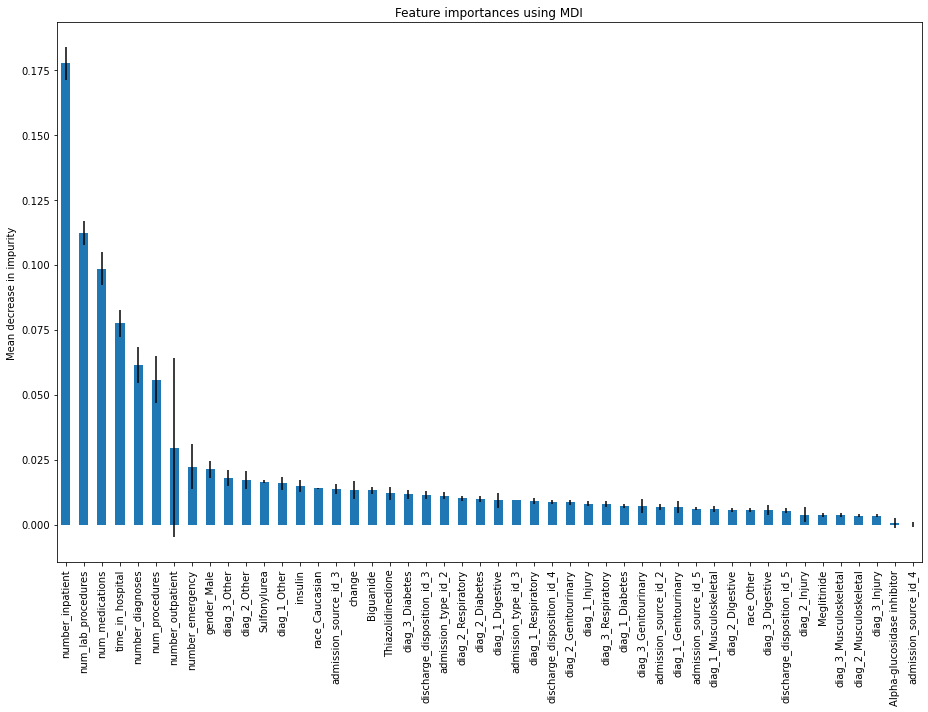

In [18]:
#Feature importance for Random Forest
importances = rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfr.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X_train.columns.to_list()).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(13, 10))
forest_importances.plot.bar(yerr=std, ax=ax,)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# XGBoost 
#### Link used: https://stackoverflow.com/questions/67868420/xgboost-for-multiclassification-and-imbalanced-data

In [19]:
#Import and initialize the XGB model
xgb_classifier = xgb.XGBClassifier()

In [20]:
#This is the best approach for imbalance data, XGBoost doesn't allow you to use class_weights
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y = train['readmitted'] 
)
#y_train = y
xgb_classifier.fit(X_train,y_train, sample_weight=sample_weights)
index=X_train.columns.to_list()

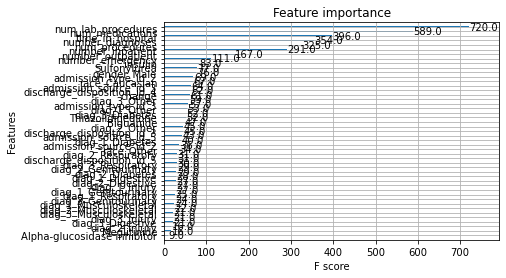

In [21]:
#Feature Importance
plot_importance(xgb_classifier)
pyplot.show()

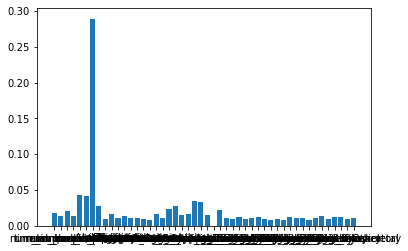

In [22]:
#Feature importance using the feature_importances_ variable of the trained model
pyplot.bar(index, xgb_classifier.feature_importances_)
plt.xticks(index)
pyplot.show()

In [23]:
#Couldn't get the graph in better shape so presenting the values in a Df
feat_imp = pd.DataFrame()
feat_imp['feature'] = index
feat_imp['importance'] = xgb_classifier.feature_importances_
feat_imp = feat_imp.sort_values(by=['importance'], ascending=False)
feat_imp.head()

,feature,importance
6,number_inpatient,0.289155
4,number_outpatient,0.042882
5,number_emergency,0.042252
22,discharge_disposition_id_5,0.034669
23,admission_source_id_2,0.032710


In [24]:
#Make predictions and print accuracy metrics
predictions = xgb_classifier.predict(X_test)
print("Accuracy of Model::", accuracy_score(y_test,predictions))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

Accuracy of Model:: 0.7936940674450306
Mean Absolute Error: 0.20630593255496948
Mean Squared Error: 0.20630593255496948
Root Mean Squared Error: 0.4542091286565798


In [25]:
#Visualize
#fig, ax = plt.subplots(figsize=(30, 30))
#xgb.plot_tree(xgb_classifier, ax=ax)
#plt.show()

# ROC Curves

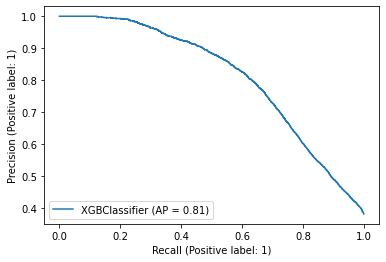

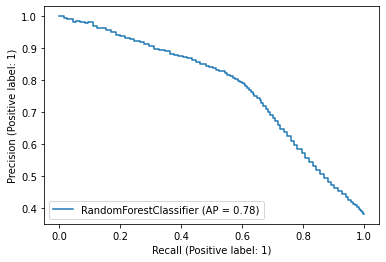

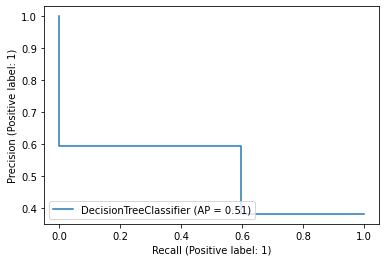

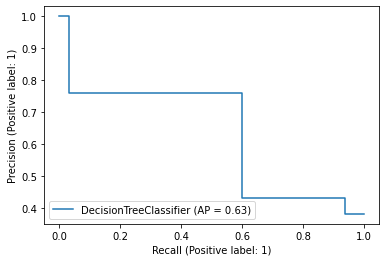

In [28]:
# Plot ROC curves

fig_1 = PrecisionRecallDisplay.from_estimator(xgb_classifier, X_test,y_test)
fig_2 = PrecisionRecallDisplay.from_estimator(rfr, X_test, y_test)
fig_3 = PrecisionRecallDisplay.from_estimator(decision_tree_1, X_test, y_test)
fig_4 = PrecisionRecallDisplay.from_estimator(decision_tree_2, X_test,y_test)

#plot = RocCurveDisplay.from_estimator(xgb_classifier, X_test,y_test)
#plot = RocCurveDisplay.from_estimator(rfr, X_test, y_test, ax=plot.ax_)
#plot = RocCurveDisplay.from_estimator(decision_tree_1, X_test, y_test,ax=plot.ax_)
#plot = RocCurveDisplay.from_estimator(decision_tree_2, X_test,y_test,ax=plot.ax_)
#plot